# **Import Statement**

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image

**Membaca data train, kemudian menampilkan 5 data teratas**

In [54]:
data=pd.read_csv("train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# **FEATURE ANALYSIS**

**Membuat variabel baru bernama target pada kolom survival untuk memprediksi apakah penumpang selamat (1) atau tidak (0)**

In [55]:
target=data["Survived"]

**Menghapus kolom yang tidak relevan seperti passengerId dan Name, lalu menghapus kolom survived karena dijadikan target prediksi. Kemudian ditampilkan 5 data teratas**

In [56]:
#features for prediction
features=data.drop(columns=['PassengerId',"Survived","Name"]) # removed passengerId and Name since they are irrelevent for prediction
features.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


**Membagi feature column menjadi categorical dan numerical**

In [57]:
categorical_features=['Sex','Ticket','Cabin','Embarked']
numerical_features=['Pclass','Age','SibSp','Parch','Fare']

# **DATA CLEANING**

**Menghapus nilai null dan fix data kategorikal**

****

In [58]:
# Mentransformasi fitur-fitur numerik dengan strategi 'mean' untuk mengisi nilai yang null dan menskalarkan fitur-fitur numerik sehingga memiliki mean nol dan variansi satu.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [59]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [60]:
# menggabungkan numerical_transformer dan categorical_transformer menjadi satu
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [61]:
X_train_processed = preprocessor.fit_transform(features)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=features.columns)
X_train_processed_df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.827377,-0.592481,0.432793,-0.473674,-0.502445,1.0,523.0,47.0,2.0
1,-1.566107,0.638789,0.432793,-0.473674,0.786845,0.0,596.0,81.0,0.0
2,0.827377,-0.284663,-0.474545,-0.473674,-0.488854,0.0,669.0,47.0,2.0
3,-1.566107,0.407926,0.432793,-0.473674,0.420730,0.0,49.0,55.0,2.0
4,0.827377,0.407926,-0.474545,-0.473674,-0.486337,1.0,472.0,47.0,2.0


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_train_processed_df, target, test_size=0.3, random_state=42) # 70-30 train-test split
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (623, 9)
y_train shape: (623,)
X_test shape: (268, 9)
y_test shape: (268,)


# **Finding The Best Model For Analysis**

**Mendefinisikan sebuah dictionary bernama models yang berisi beberapa model machine learning yang akan digunakan untuk training dan evaluasi data**

In [63]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

**Inisialisasi list untuk menyimpan hasil training dan evaluasi data**

In [64]:
# Initialize a list to store the results
results = []

****

**Training dan Evaluasi tiap model, hasilnya dimasukkan ke list result**

In [65]:
# Melatih(Train) dan mengevaluasi setiap model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    report = classification_report(y_test, y_pred, output_dict=True)  # Generate classification report
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'F1-Score_0': report['0']['f1-score'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
        'F1-Score_1': report['1']['f1-score']
    })

**Hasil training dan evaluasi yang ada pada list result dikonversi ke dalam bentuk dataframe**

In [66]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

**Mengidentifikasi model terbaik berdasarkan akurasinya**

In [67]:
# Identify the best model based on accuracy
best_model = results_df.loc[results_df['Accuracy'].idxmax()]['Model']

**Membuat bar plot untuk menampilkan hasil identifikasi model terbaik**

<ipython-input-68-94a7b0ef3f3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=results_df, palette=['blue' if model != best_model else 'red' for model in results_df['Model']])


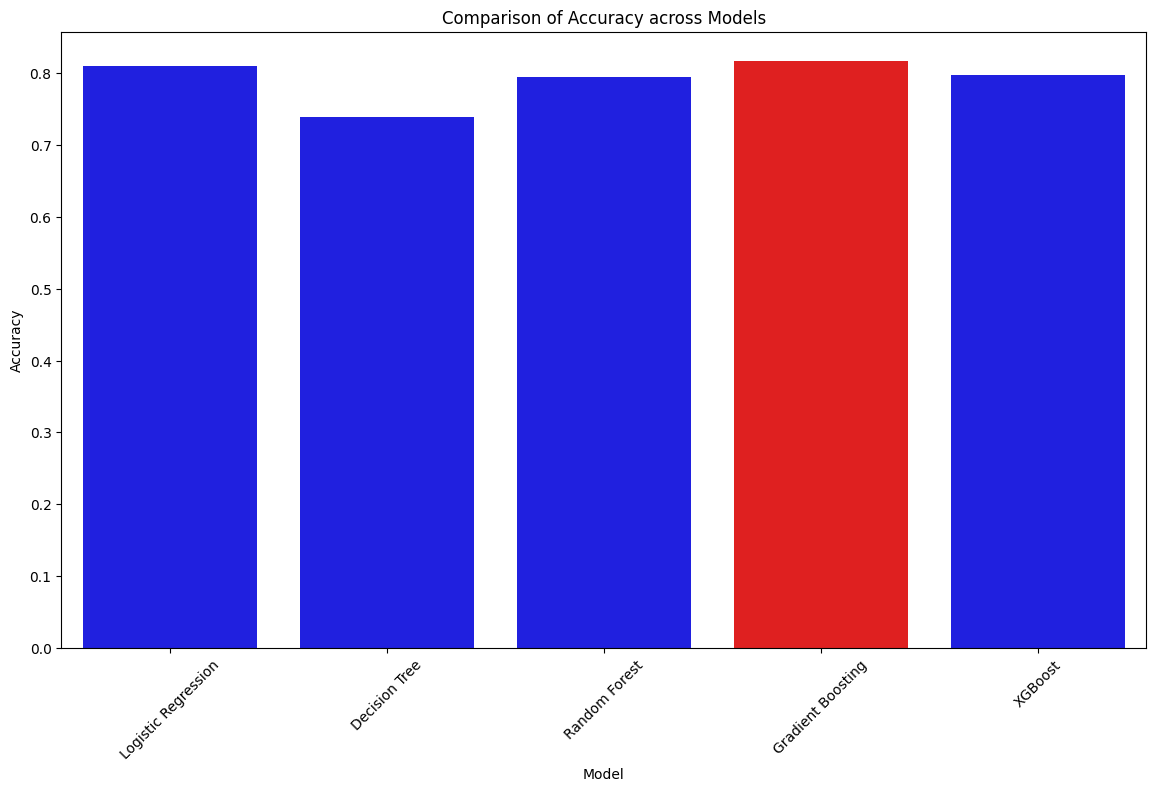

<ipython-input-68-94a7b0ef3f3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=results_df, palette=['blue' if model != best_model else 'red' for model in results_df['Model']])


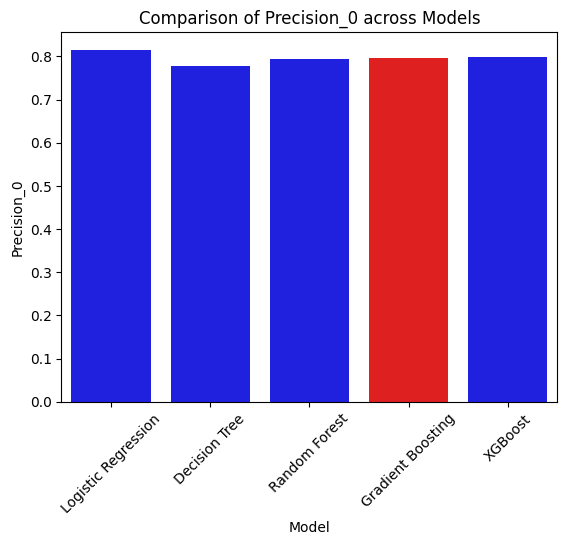

<ipython-input-68-94a7b0ef3f3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=results_df, palette=['blue' if model != best_model else 'red' for model in results_df['Model']])


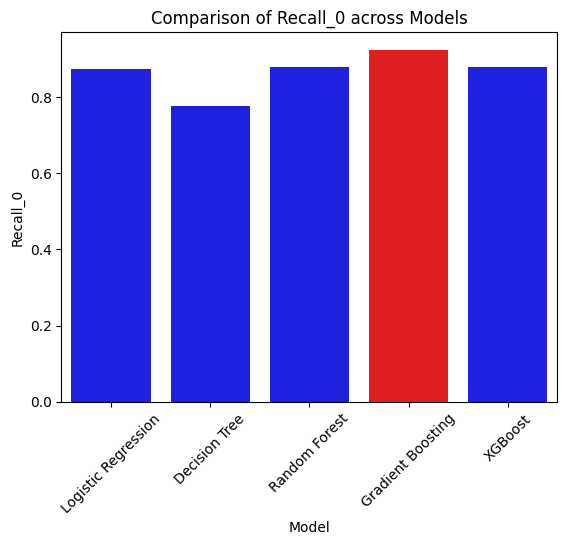

<ipython-input-68-94a7b0ef3f3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=results_df, palette=['blue' if model != best_model else 'red' for model in results_df['Model']])


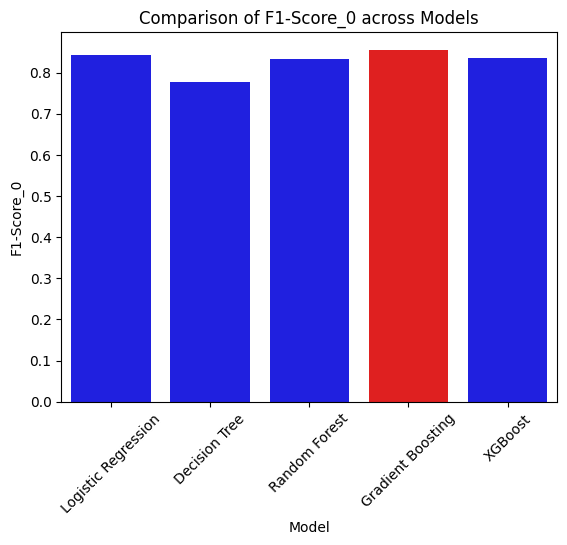

<ipython-input-68-94a7b0ef3f3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=results_df, palette=['blue' if model != best_model else 'red' for model in results_df['Model']])


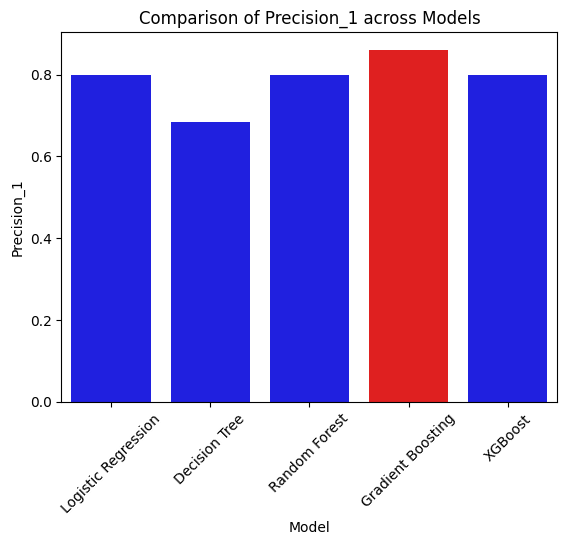

<ipython-input-68-94a7b0ef3f3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=results_df, palette=['blue' if model != best_model else 'red' for model in results_df['Model']])


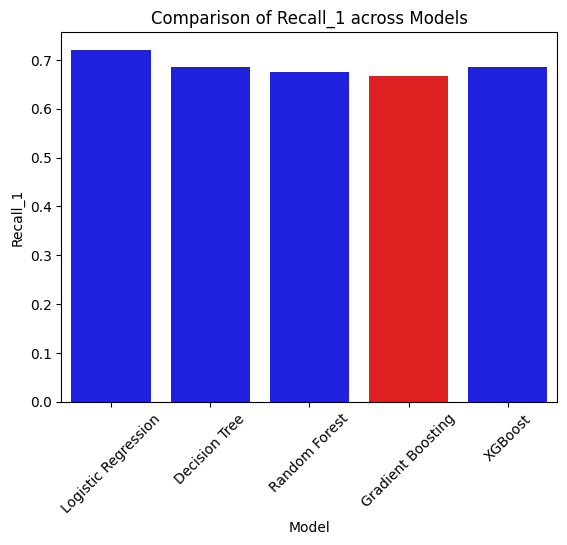

<ipython-input-68-94a7b0ef3f3d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=results_df, palette=['blue' if model != best_model else 'red' for model in results_df['Model']])


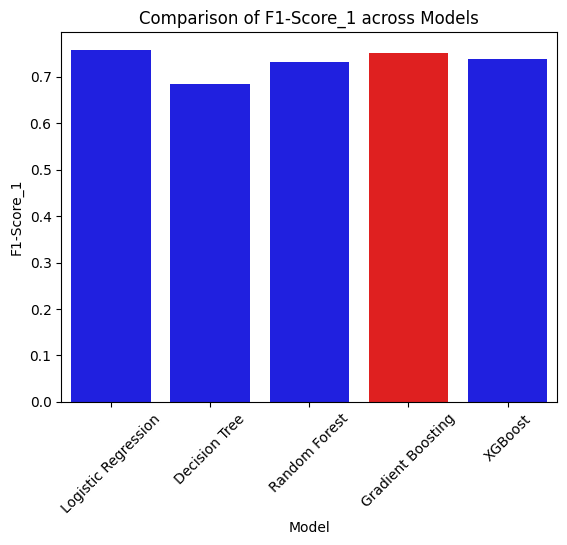

In [68]:
# Create a bar plot for the metrics
metrics = ['Accuracy', 'Precision_0', 'Recall_0', 'F1-Score_0', 'Precision_1', 'Recall_1', 'F1-Score_1']

plt.figure(figsize=(14, 8))
for metric in metrics:
    sns.barplot(x='Model', y=metric, data=results_df, palette=['blue' if model != best_model else 'red' for model in results_df['Model']])
    plt.title(f'Comparison of {metric} across Models')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()

**Menampilkan hasil dari konversi dataframe result**

In [69]:
output = pd.DataFrame(results)
print(output)

                 Model  Accuracy  Precision_0  Recall_0  F1-Score_0  \
0  Logistic Regression  0.809701     0.815476  0.872611    0.843077   
1        Decision Tree  0.738806     0.777070  0.777070    0.777070   
2        Random Forest  0.794776     0.793103  0.878981    0.833837   
3    Gradient Boosting  0.817164     0.796703  0.923567    0.855457   
4              XGBoost  0.798507     0.797688  0.878981    0.836364   

   Precision_1  Recall_1  F1-Score_1  
0     0.800000  0.720721    0.758294  
1     0.684685  0.684685    0.684685  
2     0.797872  0.675676    0.731707  
3     0.860465  0.666667    0.751269  
4     0.800000  0.684685    0.737864  


**Memilih salah satu tree untuk divisualisasikan (misal tree pertama)**

In [70]:
estimator = models['Gradient Boosting'].estimators_[0, 0]

**Mengekspor tree ke format DOT**

In [71]:
dot_data = export_graphviz(estimator, out_file=None,
                           feature_names=features.columns,
                           class_names=['Not Survived', 'Survived'],
                           filled=True, rounded=True,
                           special_characters=True)

**Menggunakan graphviz untuk merender file DOT dan menampilkannya**

In [72]:
graph = graphviz.Source(dot_data)
graph.render("gradient_boosting_tree",format="png")  # menyimpan visualisasi tree ke format png

'gradient_boosting_tree.png'

**Menampilkan gambar dari gradient boosting tree**

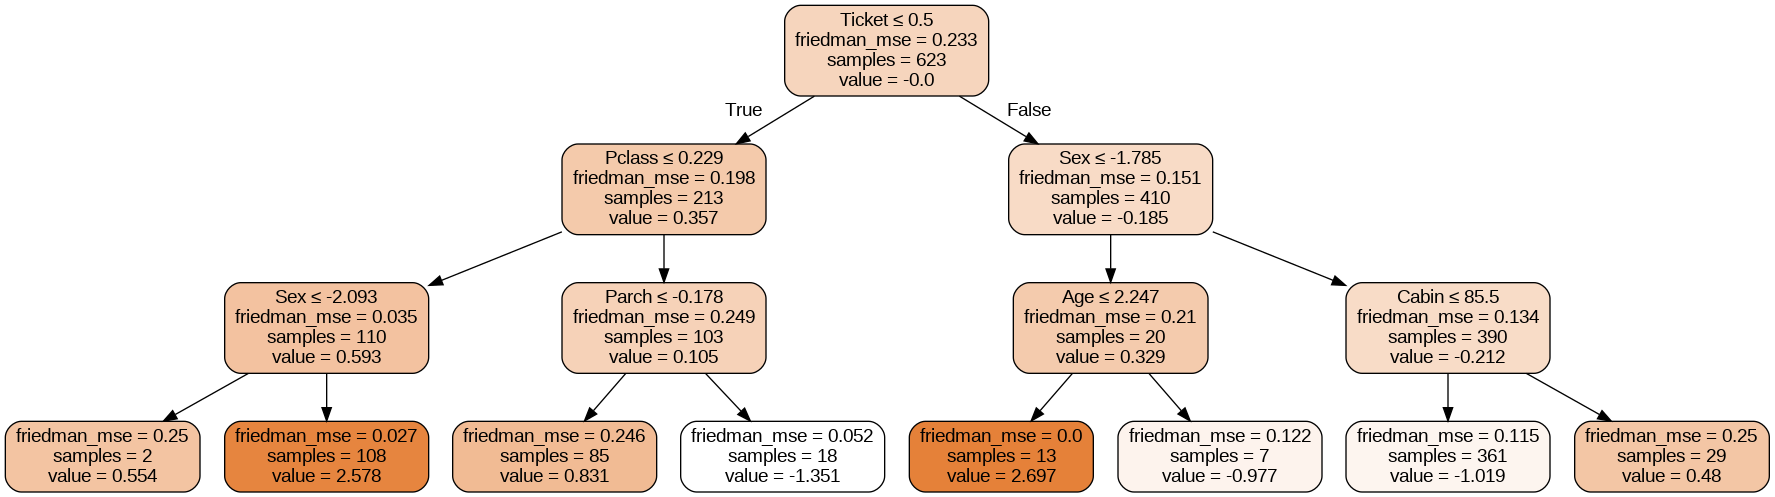

In [73]:
Image(filename="gradient_boosting_tree.png")

# **PREDICTION**

**Membaca data test, kemudian menampilkan 5 data teratas**

In [74]:
test_data=pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Menghapus kolom PassengerId dan Name karena kolom-kolom tersebut tidak diperlukan untuk prediksi. Kemudian menerapkan pipeline preprocessing pada data yang sudah dibersihkan. Setelah itu Mengonversi data yang sudah diproses kembali menjadi DataFrame pandas**

In [75]:
X_submission = test_data.drop(columns=["PassengerId","Name"])  # Drop 'id' and name column

X_train_processed = preprocessor.fit_transform(X_submission)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=features.columns)

**Memprediksi data test menggunakan Gradient Boosting Classifier**

In [76]:
# Prediction on test data using Gradient Boosting Classifier
predictions = models['Gradient Boosting'].predict(X_train_processed_df)

**Membuat sebuah DataFrame baru bernama submission_df yang memiliki dua kolom, yaitu passengerId dan survived yang diambil dari dataframe test_data untuk mengidentifikasi hasil prediksi model apakah penumpang selamat (1) atau tidak selamat (0)**

In [77]:
#Mapping the Values Back to Strings
submission_df = pd.DataFrame({"PassengerId": test_data["PassengerId"], 'Survived': predictions})

**Menyimpan DataFrame submission_df ke dalam file CSV dengan nama 'submission.csv', lalu menampilkan isi data submission_df**

In [78]:
# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print(submission_df)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
